<a href="https://colab.research.google.com/github/Evandro72/LDA-Five-Topics/blob/main/LDA_Five_Topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from os import walk
import pandas as pd
import json
import matplotlib.pyplot as plt
import re
import string
import nltk
import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
pd.set_option("display.max_colwidth", 200)
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from nltk.corpus import wordnet

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#### Read the tweets from the file

In [ ]:
data = pd.read_csv("./Tweets.csv")

In [ ]:
tweets = data[data["Language"]=="English"]["Tweet"].tolist()

In [ ]:
len(tweets)

6323

### Preprocessing

In [ ]:
def removeInputPattern(pattern, inputString):
    inputString=re.sub(pattern,"",inputString)
    return inputString 

In [ ]:
cleaned_tweets=[]
for line in tweets:
    cleaned_tweets.append(removeInputPattern(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|@[\w]+",str(line)))

#### Remove Stop Words

In [ ]:
listStopwords = nltk.corpus.stopwords.words("english")

In [ ]:
def removeStopWords(text,listStopwords=listStopwords):
    listText = text.split()
    if listStopwords is not None:
        listText = [word for word in listText if word not in listStopwords]
        
    text = " ".join(listText)
    return text
    

In [ ]:
cleaned_tweets = map(removeStopWords,cleaned_tweets)
cleaned_tweets = list(cleaned_tweets)

In [ ]:
# Remove Emails
cleaned_tweets = [re.sub('\S*@\S*\s?', '', sent) for sent in cleaned_tweets]

# Remove new line characters
cleaned_tweets = [re.sub('\s+', ' ', sent) for sent in cleaned_tweets]

# Remove distracting single quotes
cleaned_tweets = [re.sub("\'", "", sent) for sent in cleaned_tweets]

#### Tokenize each tweet and remove punctuations

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(cleaned_tweets))
data_words = [words for words in data_words if len(words)>0]
print(data_words[:1])

[['in', 'love', 'ujweekend', 'see']]


 #### Build Bigram and Trigram Models

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [ ]:
import spacy

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

run this to download en model from spacy  
!python3 -m spacy download en

In [ ]:
# Create Bigrams o
data_words_bigrams = make_bigrams(data_words)

# Initialize the spacy 'en' model for lemmatization purpose, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])

# Perform lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['love', 'ujweekend']]


### Topic Modelling

In [ ]:
# The two important inputs to the LDA topic model are the dictionary(id2word) and the corpus. So, let’s create them.
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])



[[(0, 1), (1, 1)]]


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=400,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
for each_topic in lda_model.print_topics():
    print(each_topic)
    print("\n")

(0, '0.050*"see" + 0.032*"concert" + 0.030*"night" + 0.024*"love" + 0.023*"go" + 0.022*"get" + 0.022*"m" + 0.020*"let" + 0.020*"last" + 0.015*"soon"')


(1, '0.078*"jazz" + 0.054*"great" + 0.031*"thank" + 0.025*"good" + 0.024*"come" + 0.019*"com" + 0.019*"umbria" + 0.017*"festival" + 0.014*"orvieto" + 0.014*"year"')


(2, '0.068*"live" + 0.053*"amp" + 0.039*"tonight" + 0.030*"winter" + 0.030*"today" + 0.024*"trio" + 0.015*"www" + 0.012*"stay_human" + 0.011*"s" + 0.009*"ore"')


(3, '0.029*"be" + 0.026*"wait" + 0.026*"pleasuremoment" + 0.025*"play" + 0.023*"now" + 0.021*"ujw" + 0.014*"girl" + 0.013*"just" + 0.013*"hag" + 0.013*"sapete"')


(4, '0.162*"umbriajazz" + 0.041*"perugia" + 0.032*"music" + 0.028*"day" + 0.018*"luglio" + 0.018*"nice" + 0.017*"show" + 0.015*"time" + 0.014*"ticket" + 0.013*"band"')




In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4512968037546539


In [ ]:
list_tweets = [" ".join(words) for words in data_words]

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                #print(topic_keywords)
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=list_tweets)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.2910   
1            1             0.0              0.2910   
2            2             4.0              0.2883   
3            3             2.0              0.3447   
4            4             4.0              0.2883   
5            5             2.0              0.5264   
6            6             3.0              0.3282   
7            7             2.0              0.4274   
8            8             2.0              0.4738   
9            9             1.0              0.7063   

                                                                  Keywords  \
0                   see, concert, night, love, go, get, m, let, last, soon   
1                   see, concert, night, love, go, get, m, let, last, soon   
2  umbriajazz, perugia, music, day, luglio, nice, show, time, ticket, band   
3         live, amp, tonight, winter, today, trio, www, stay_human, s, ore   
4  umbriajazz, perugia, music, day, luglio, nice, show, time, ticket, band   
5         live, amp, tonight, winter, today, trio, www, stay_human, s, ore   
6        be, wait, pleasuremoment, play, now, ujw, girl, just, hag, sapete   
7         live, amp, tonight, winter, today, trio, www, stay_human, s, ore   
8         live, amp, tonight, winter, today, trio, www, stay_human, s, ore   
9     jazz, great, thank, good, come, com, umbria, festival, orvieto, year   

                                                                                                                                                                              Text  
0                                                                                                                                                            in love ujweekend see  
1                                                                                                                                                             what night ujweekend  
2                                                                                                                                     terni umbria jazz back town terni umbriajazz  
3                                                                                                                                                            palco terni ben fatto  
4                                                                                                                                             ramseylewis ph giancarlo belfiore uj  
5                                                                                     club ujweekend scopri il programma completo dei club di umbria jazz weekend entrata gratuita  
6                                                                                                                               happy birthday maestro tanti auguri perugia family  
7                                                                                                                    𝗥𝗼𝗮𝗱 𝘁𝗼 𝘂𝗷𝘄𝗲𝗲𝗸𝗲𝗻𝗱 anfiteatro romano quartet we wonder tickets  
8                                                                                                                        𝗥𝗼𝗮𝗱 𝘁𝗼 𝘂𝗷𝘄𝗲𝗲𝗸𝗲𝗻𝗱 anfiteatro romano romantic tour tickets  
9  my name alison jazz singer thanks umbria excellencies pleasure let discover beauties umbria land rich villages extraordinary places umbria umbriajazz umbriatourism italy model

In [ ]:
df_dominant_topic.to_excel("LDA results Five Topics.xlsx",index=False)

In [ ]:
# Define a function to plot word cloud
from wordcloud import WordCloud, STOPWORDS
def plot_cloud(text):
    wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

#### Merging Tweet Text based on Topics

In [ ]:
topic_one_text = "".join(df_dominant_topic[df_dominant_topic["Dominant_Topic"]==0]["Text"].tolist())
topic_two_text = "".join(df_dominant_topic[df_dominant_topic["Dominant_Topic"]==1]["Text"].tolist())
topic_three_text = "".join(df_dominant_topic[df_dominant_topic["Dominant_Topic"]==2]["Text"].tolist())
topic_four_text = "".join(df_dominant_topic[df_dominant_topic["Dominant_Topic"]==3]["Text"].tolist())
topic_five_text = "".join(df_dominant_topic[df_dominant_topic["Dominant_Topic"]==4]["Text"].tolist())

### Generating WordCloud from the tweets based on the topics

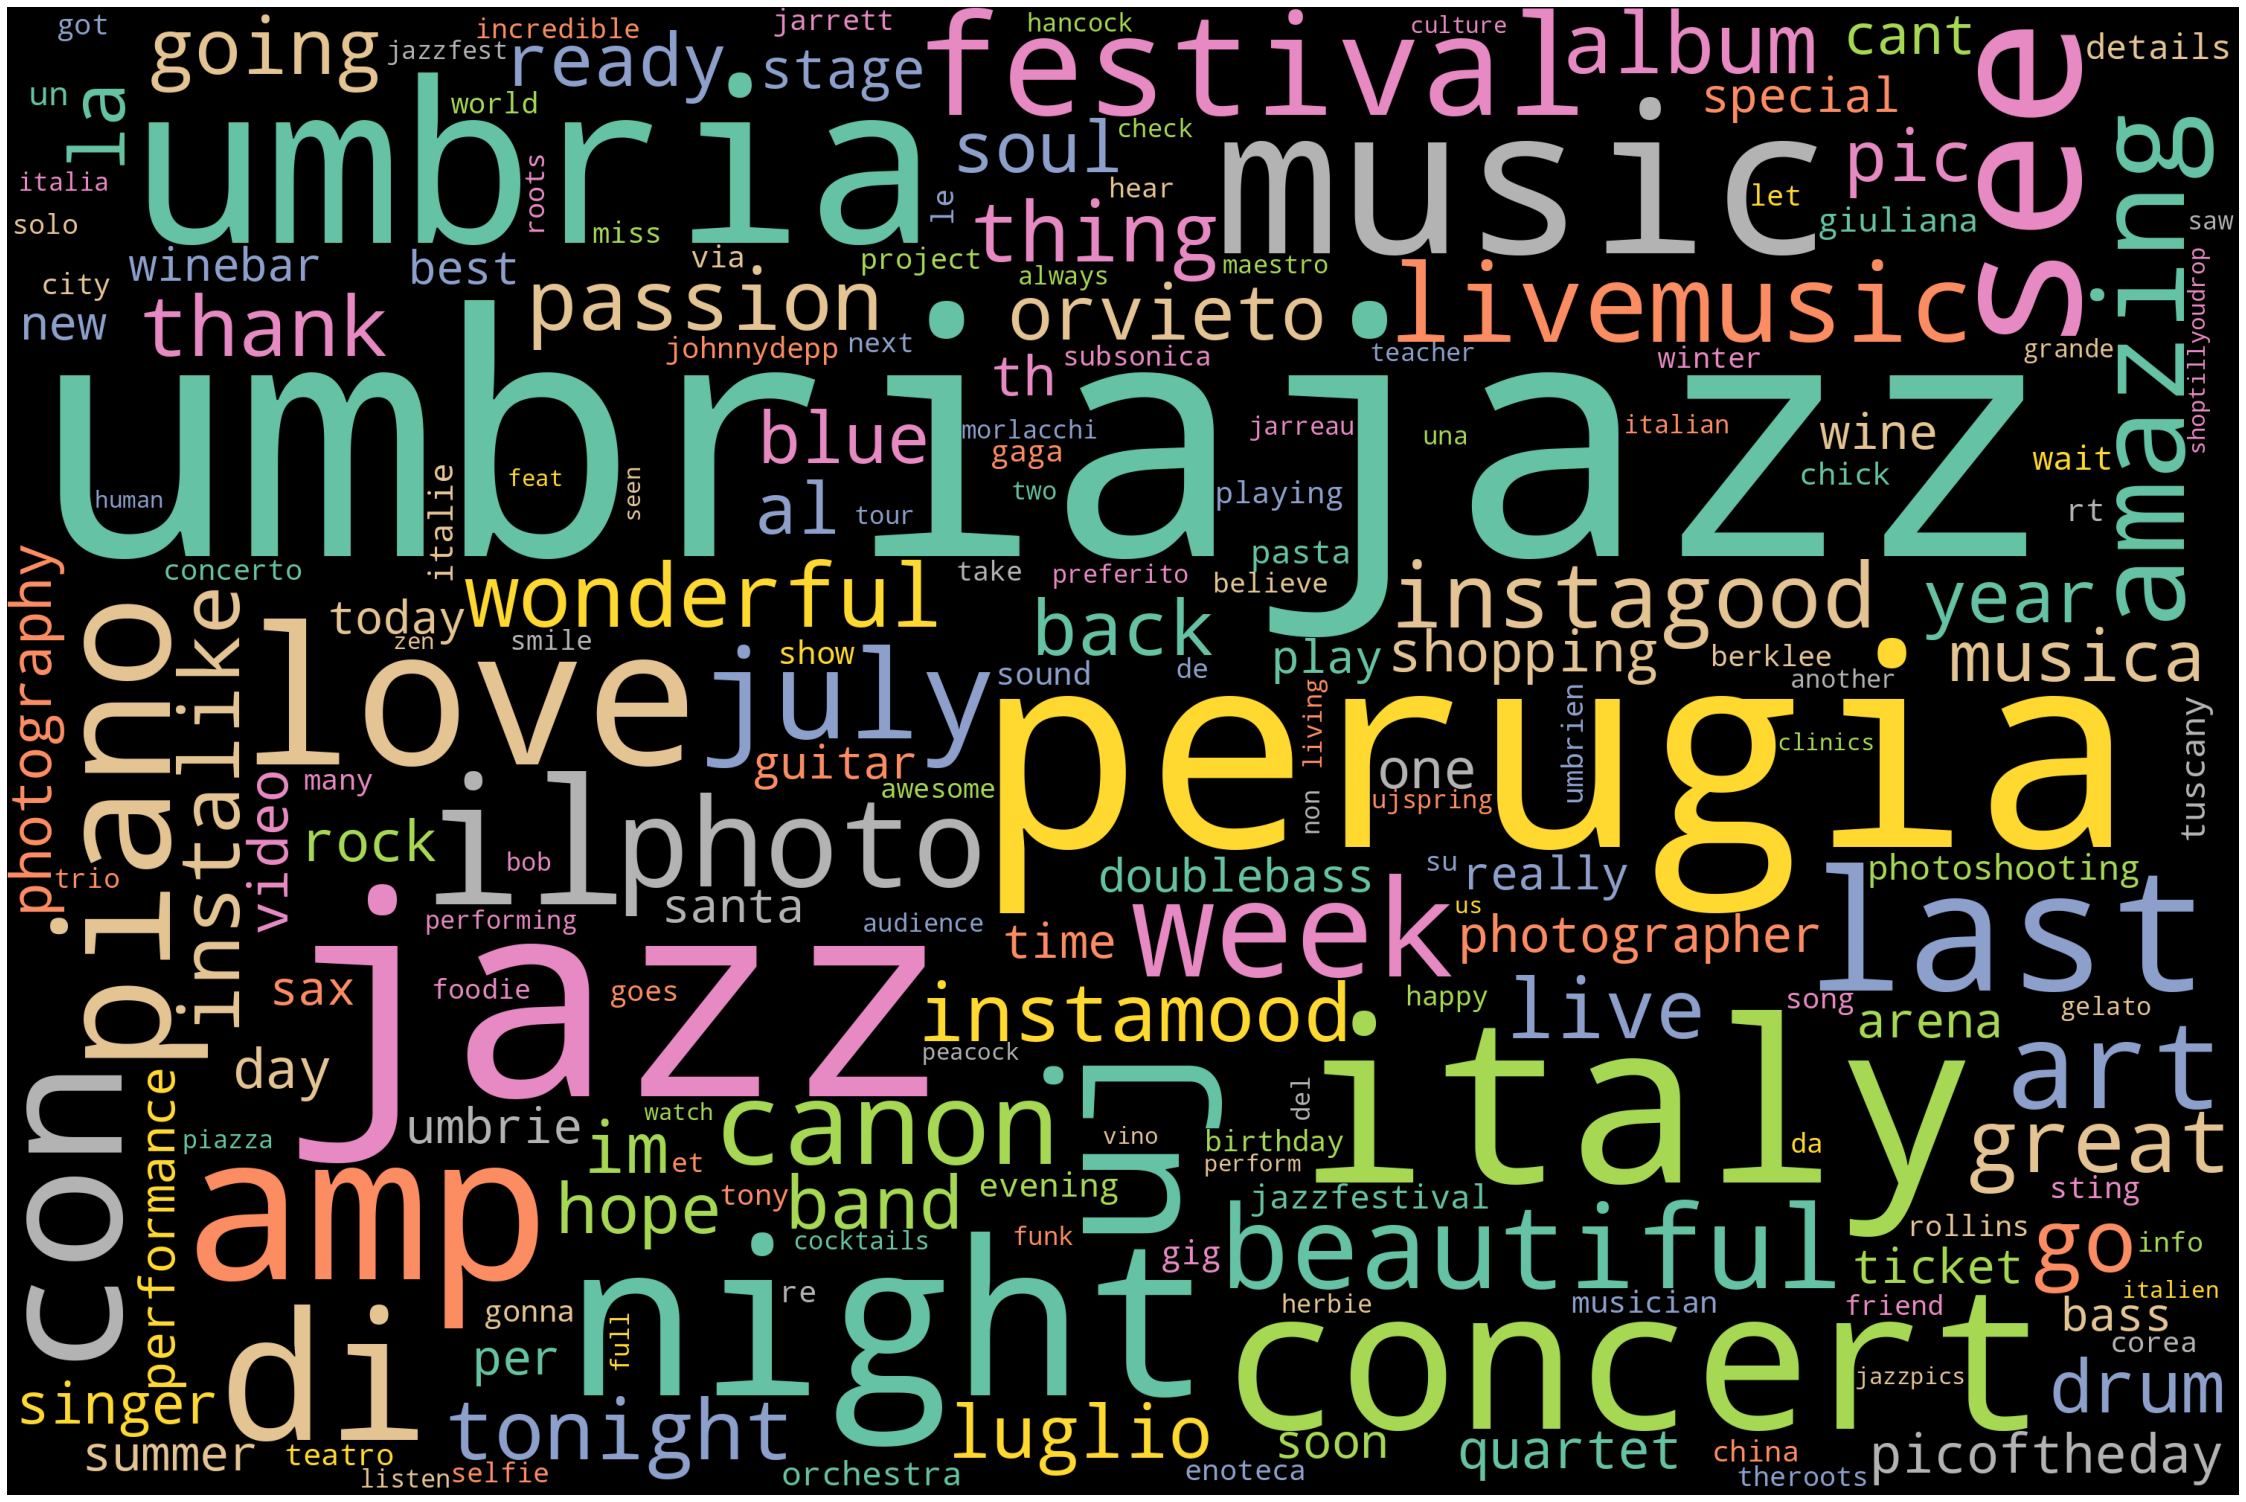

In [ ]:
plot_cloud(topic_one_text)

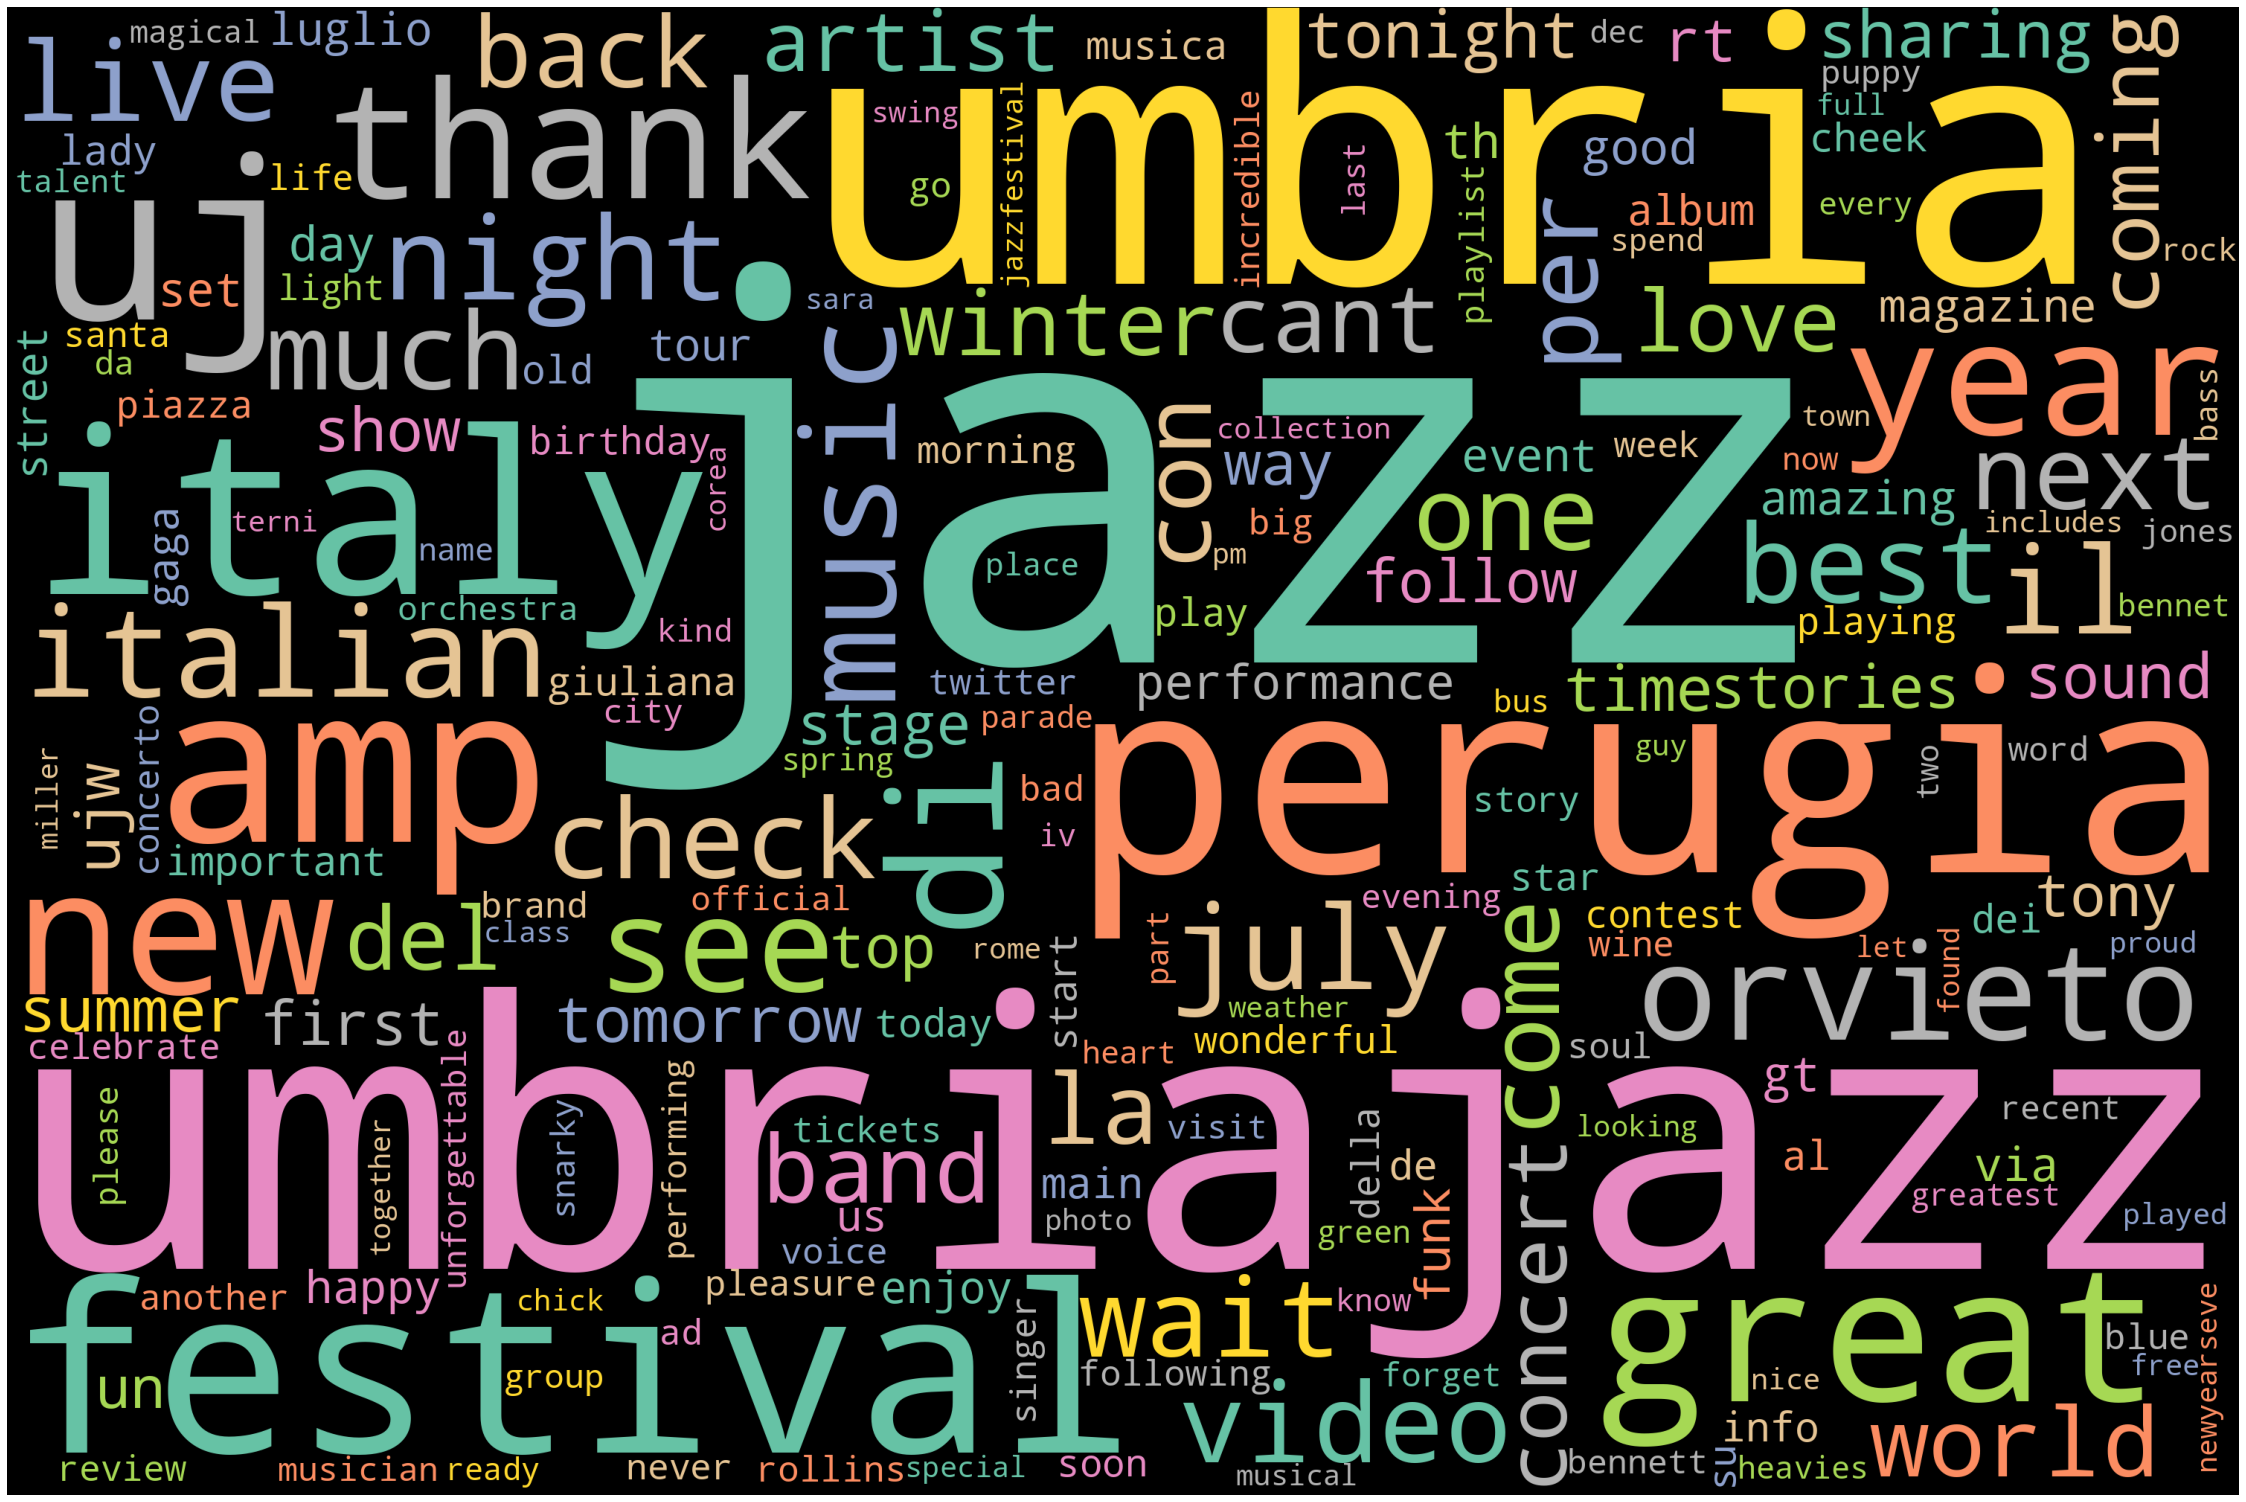

In [ ]:
plot_cloud(topic_two_text)

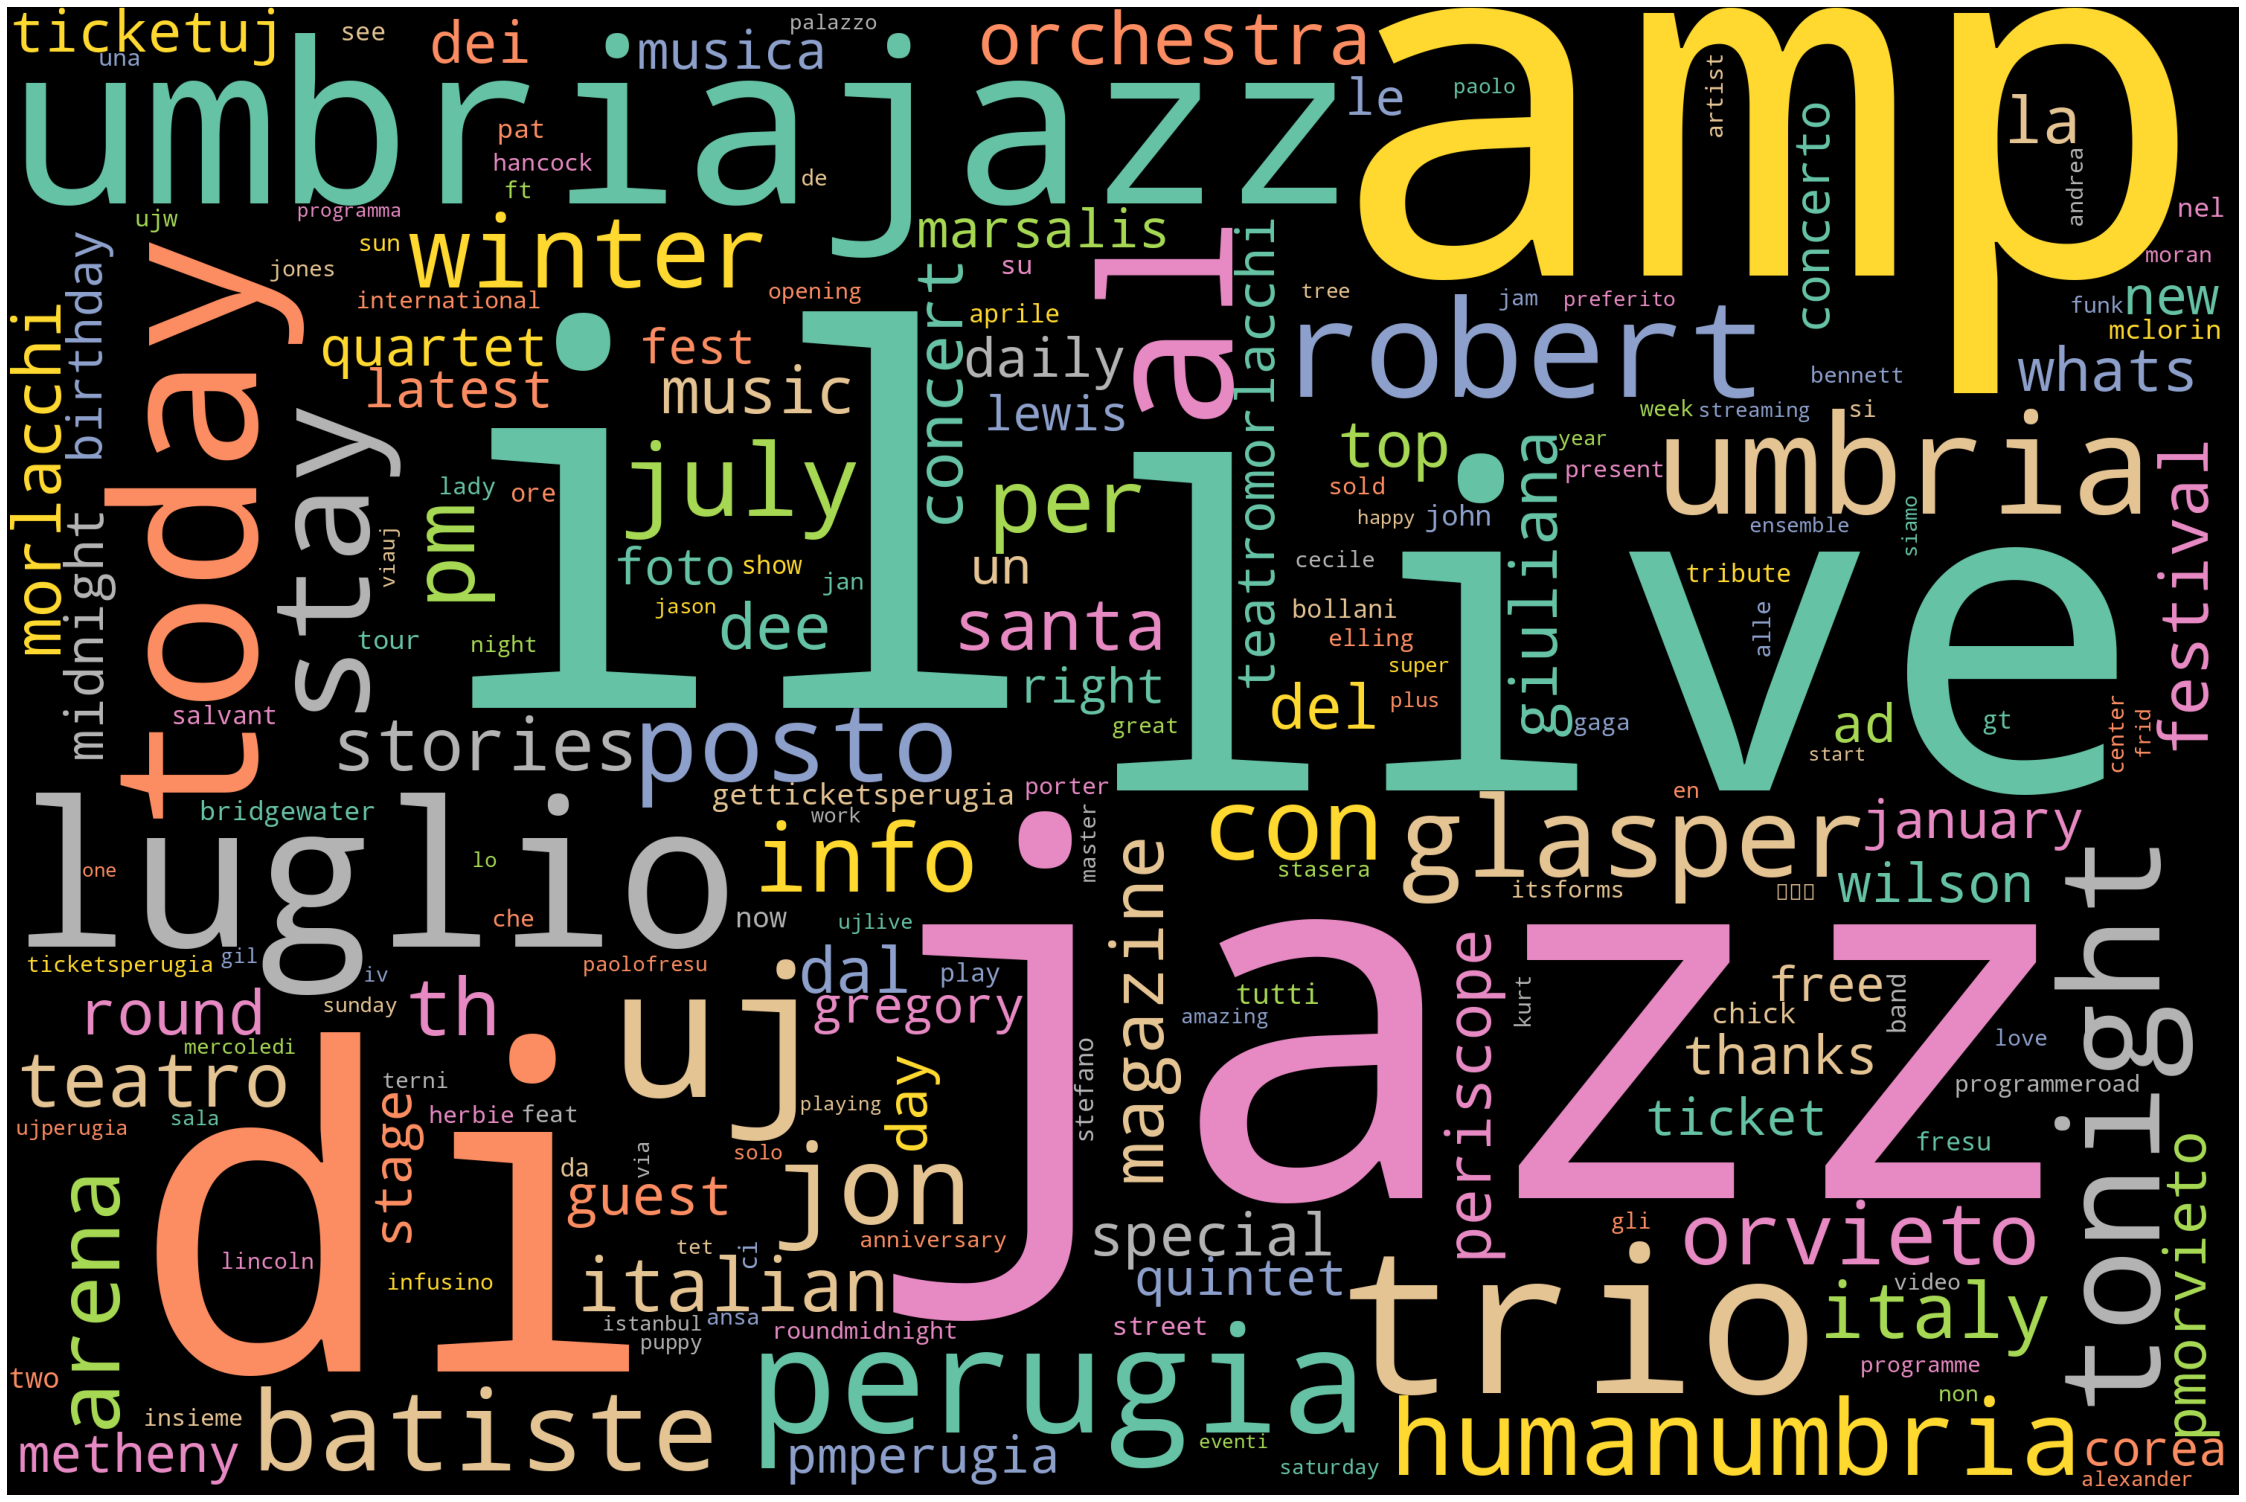

In [ ]:
plot_cloud(topic_three_text)

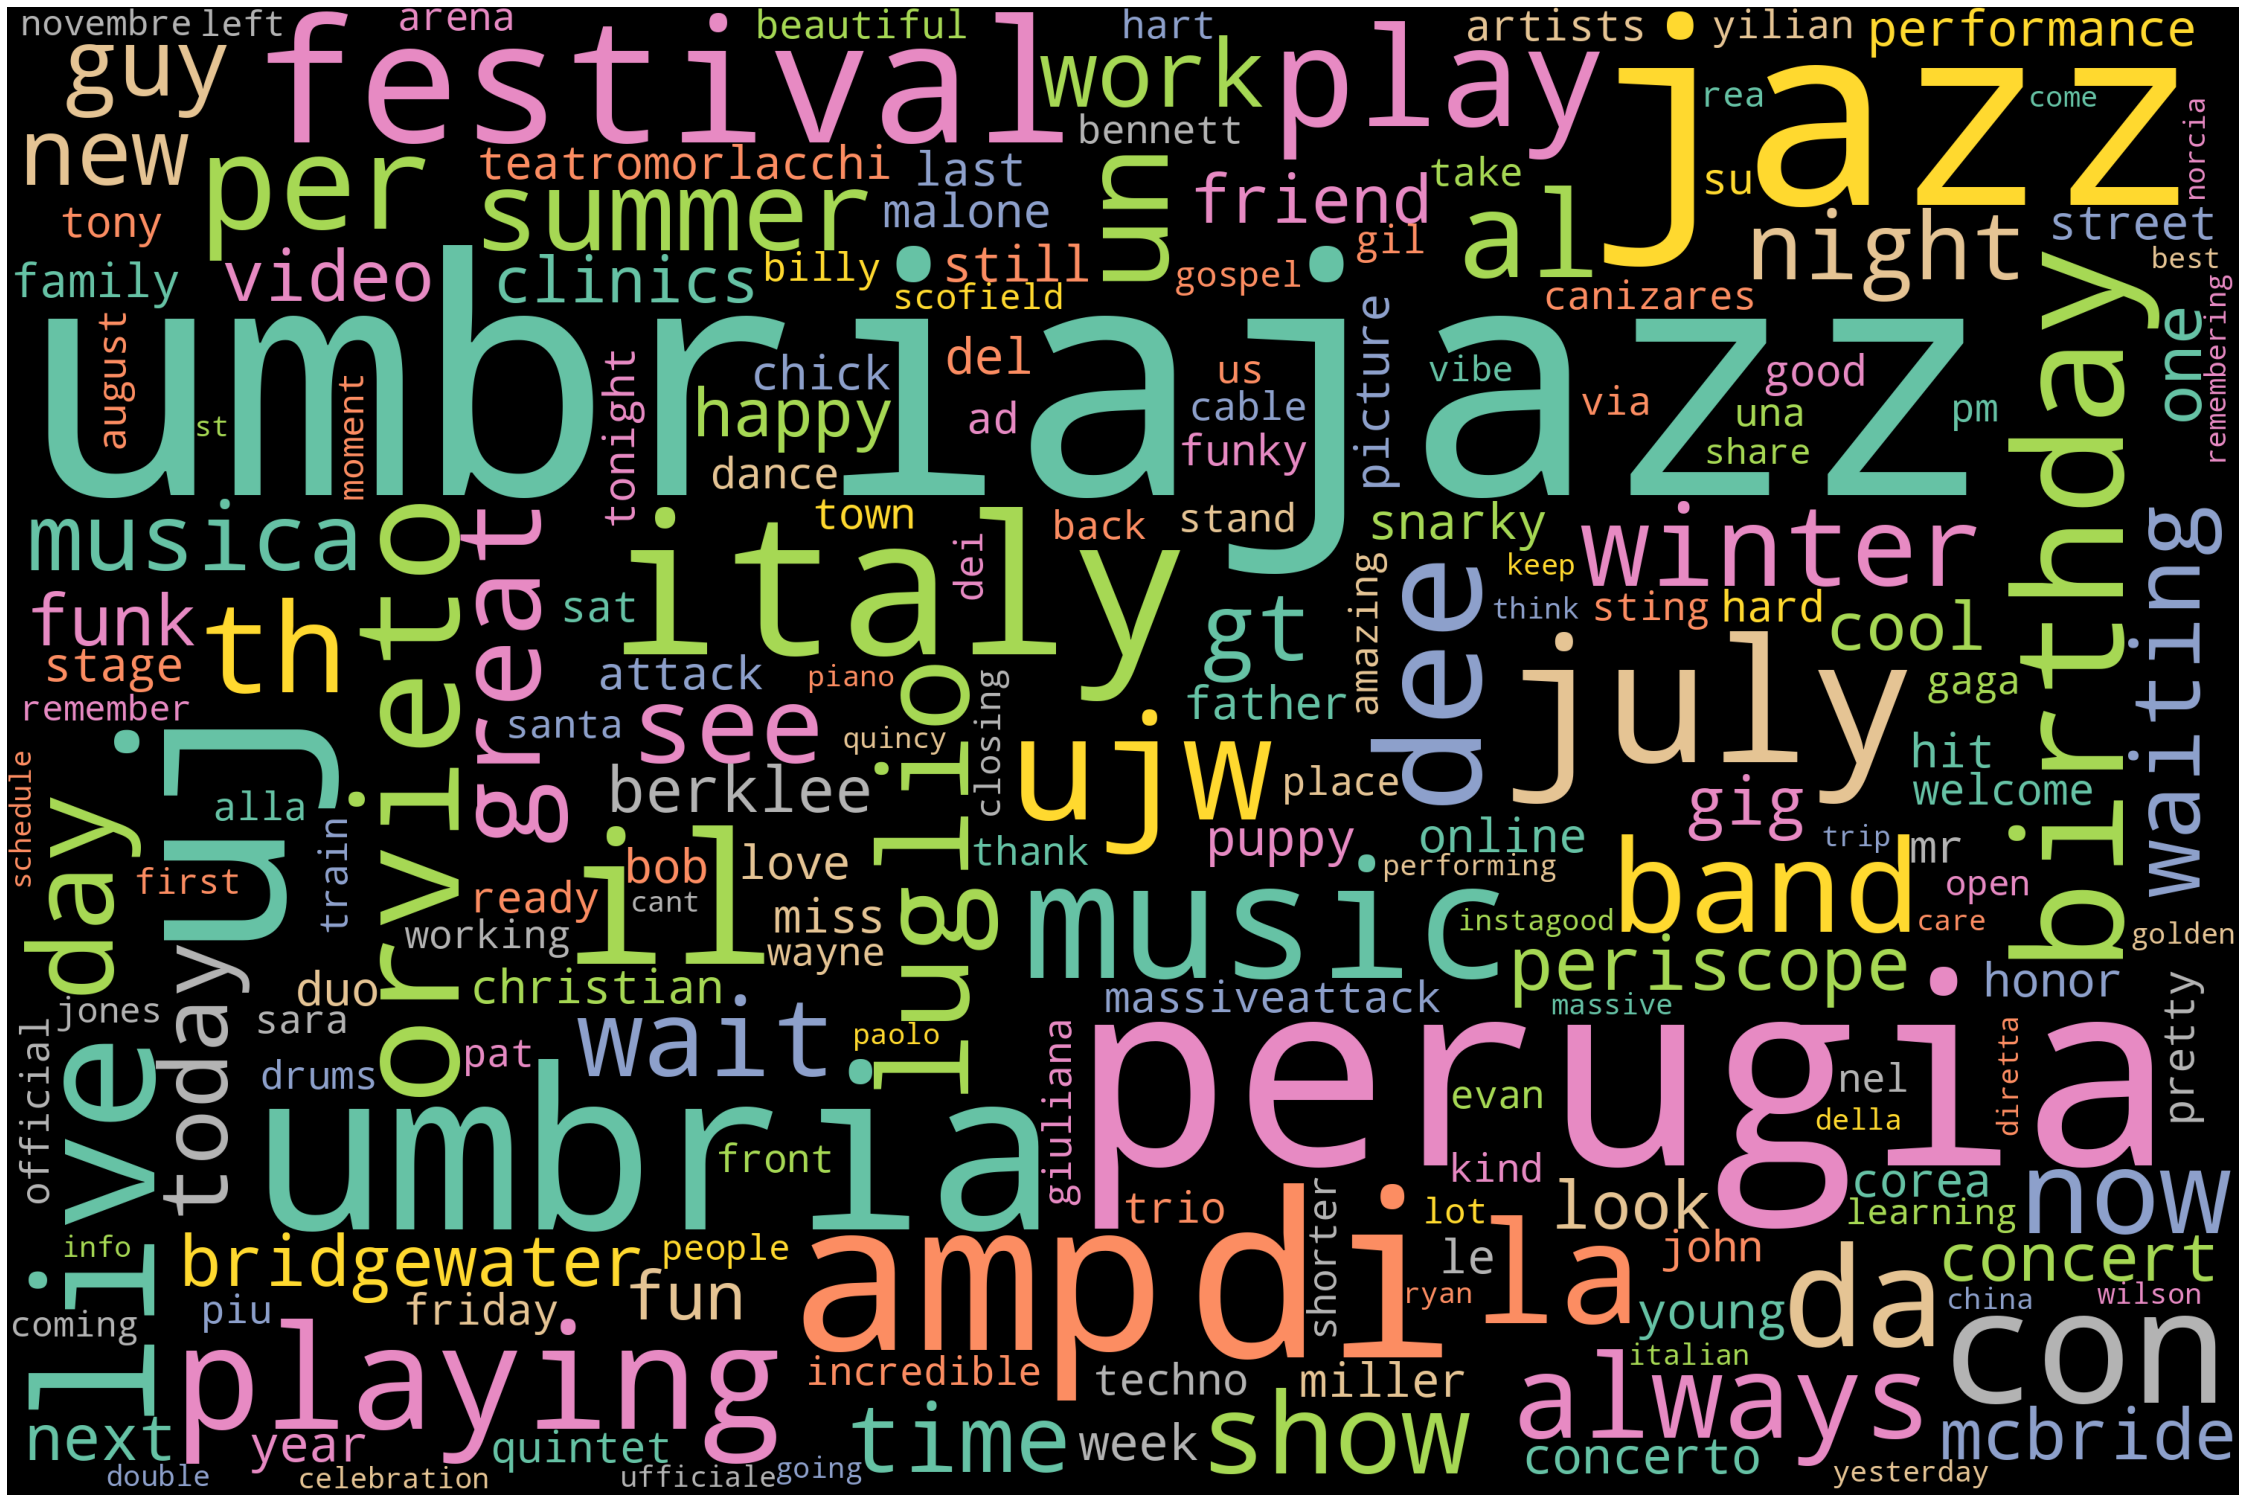

In [ ]:
plot_cloud(topic_four_text)

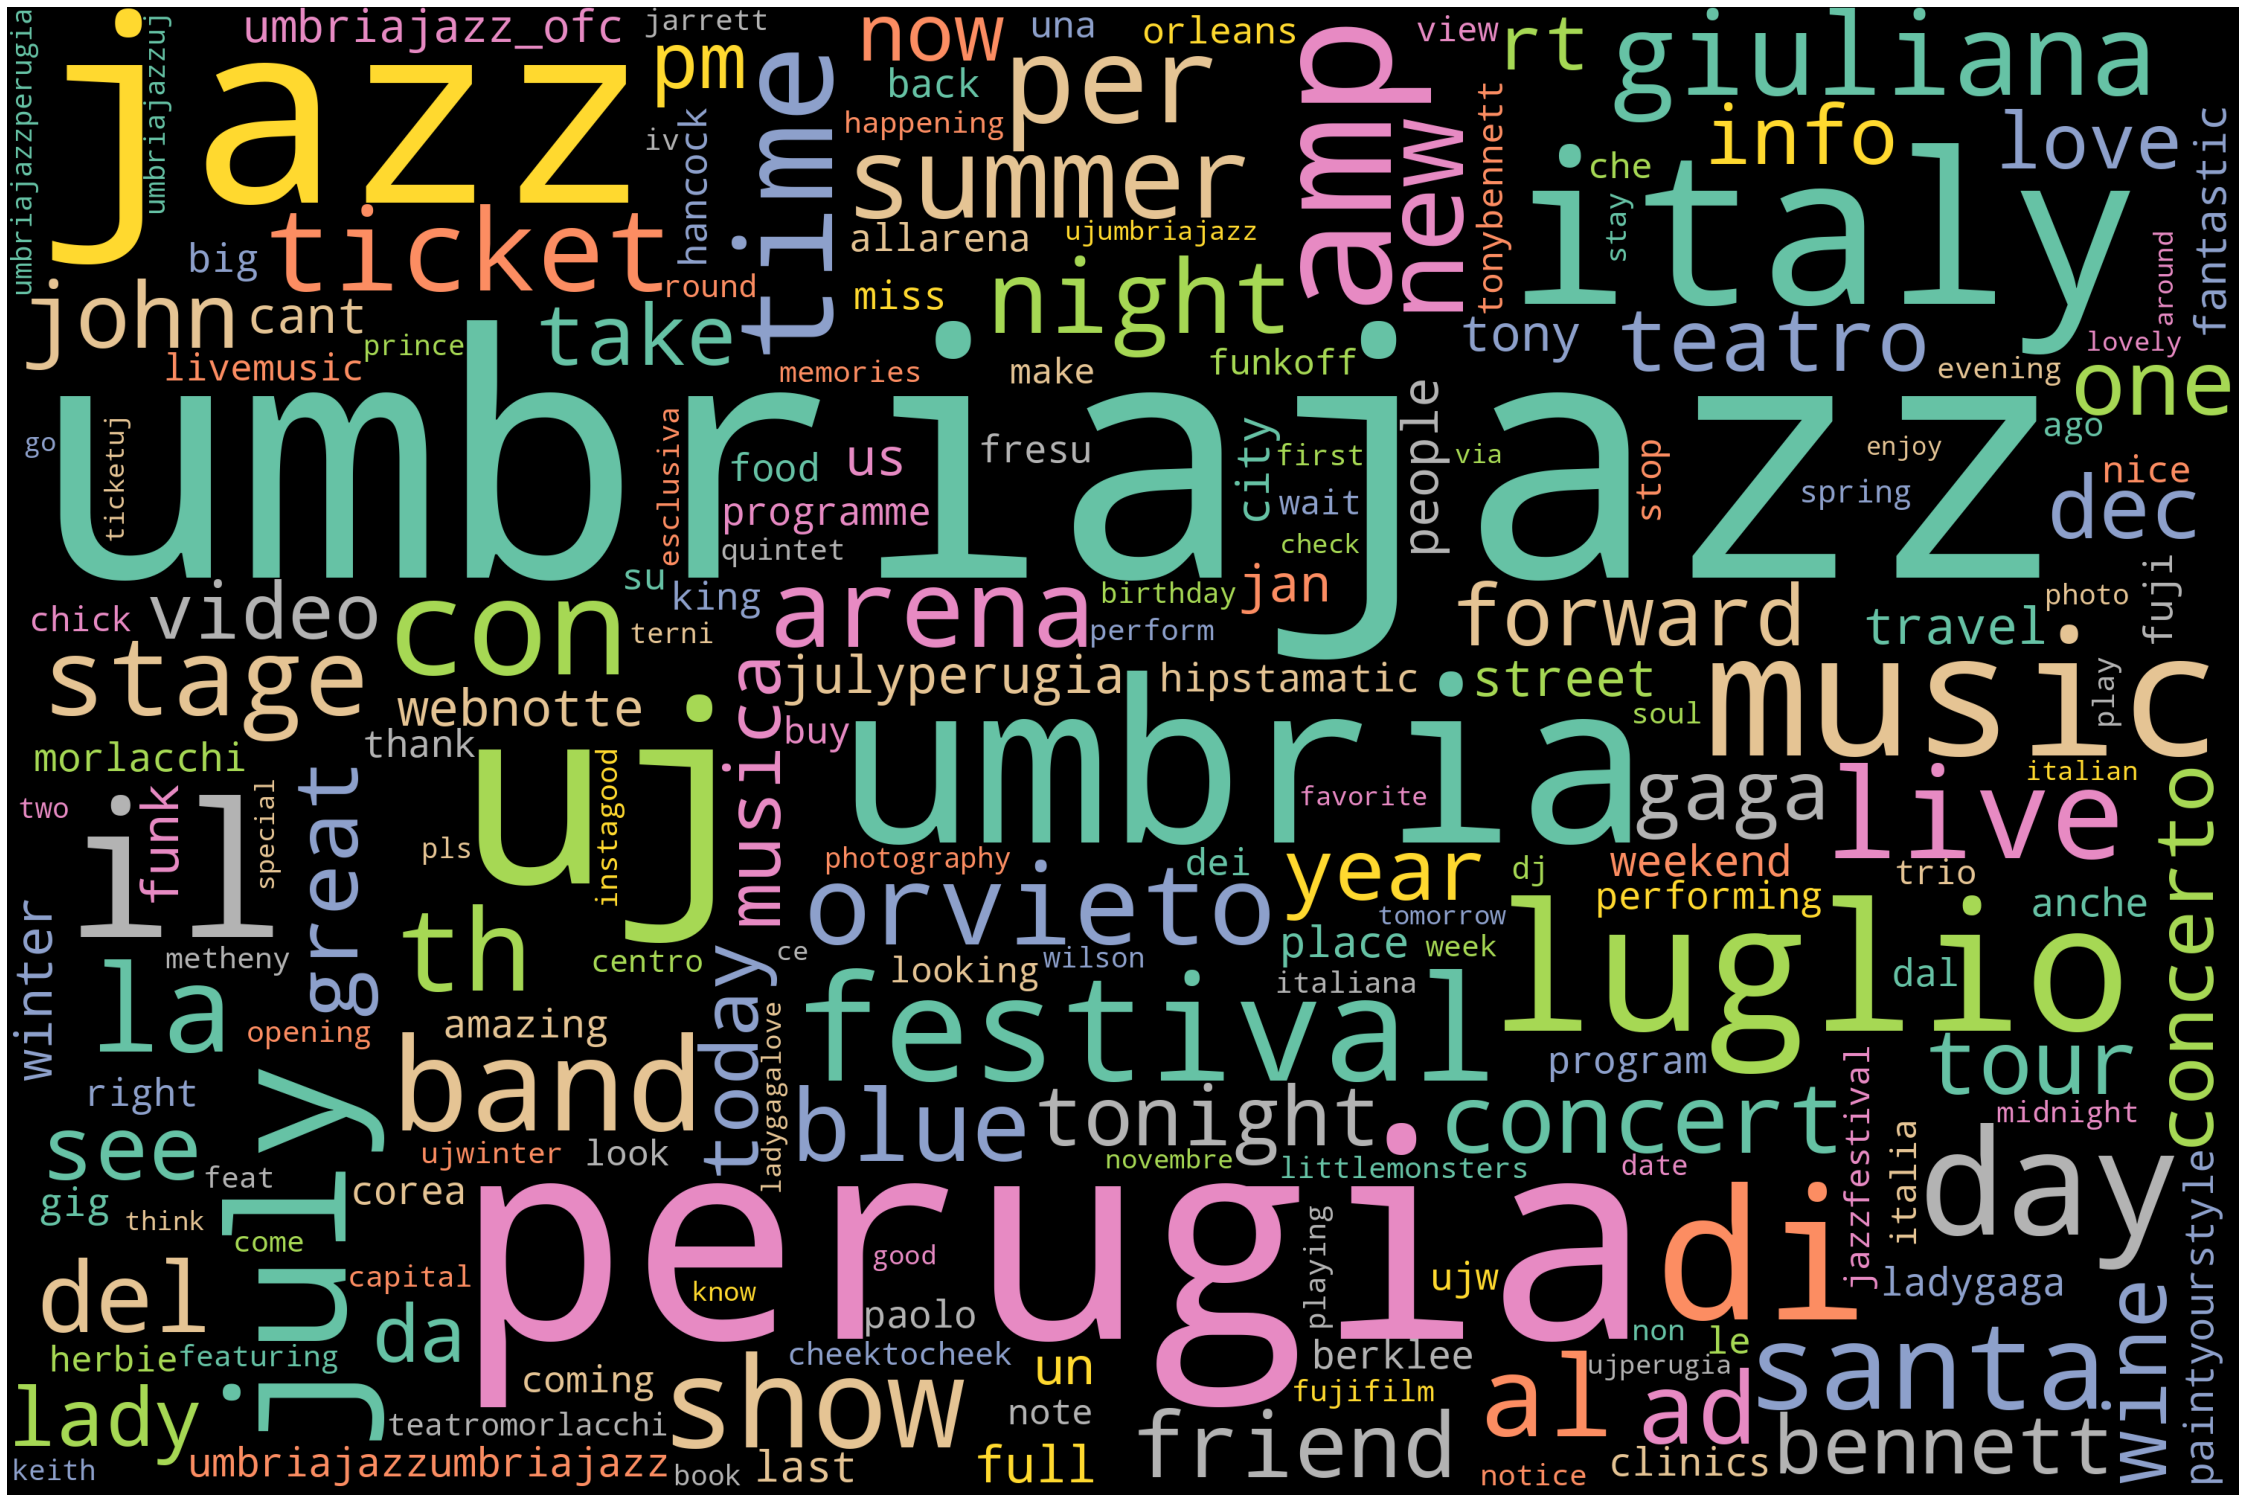

In [ ]:
plot_cloud(topic_five_text)